# Image classification using CNNs in Keras

**Data Description:**

The dataset includes images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.

**Dataset**

The data file names are:


*   images.npy
*   Label.csv


# Import all necessary modules and load the data

In [ ]:
# Import necessary modules.

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Defining the paths of the datasets
project_path = '/content/drive/My Drive/Colab Notebooks/UT_Austin/Computer_Vision/Project/'
labels_path = project_path + 'Labels.csv'
images_path = project_path + 'images.npy'

In [ ]:
# Loading the datasets
images = np.load(images_path)
labels = pd.read_csv(labels_path)

In [ ]:
# Shape of images dataset
print('Shape of images:', images.shape)

# Shape of labels dataset
print('Shape of labels:', labels.shape)

Shape of images: (4750, 128, 128, 3)
Shape of labels: (4750, 1)


*   The dataset is made of 4750 color images and labels.
*   Images are in (R, G, B) format with a resolution of 128 x 128 pixels.

In [ ]:
# Diplaying the different plant species
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

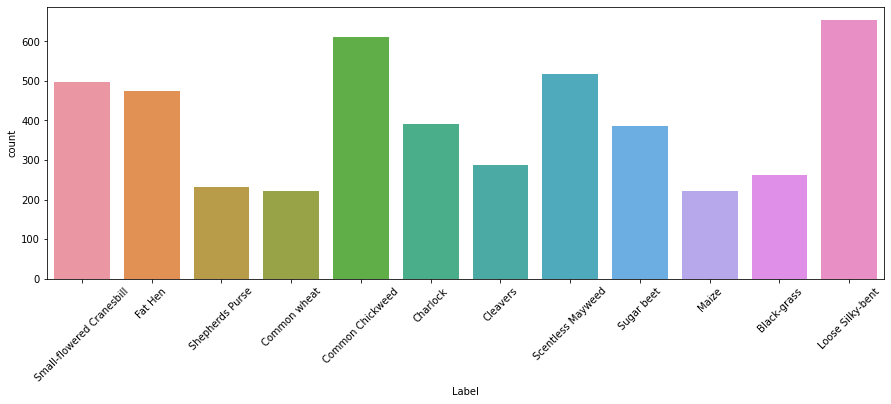

In [ ]:
# Displaying labels dataset
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.countplot(x="Label", data=labels);

 

*   The dataset includes 12 different plant species.
*   It is imbalanced as there is not an equal number of images per plant species.
*   The species the most represented is the `Loose Silky-bent` with 654 images while the species the least represented is the `Common wheat` or `Maize` with 221 images.

In [ ]:
# Indexes from which plant species changes in  list of labels
indexes = [0]
for i in range(len(labels) - 1):
  if labels.iloc[i,0] != labels.iloc[i+1,0]:
    indexes.append(i+1)
indexes

[0, 496, 971, 1202, 1423, 2034, 2424, 2711, 3227, 3612, 3833, 4096]

In [ ]:
# Visualizing some of the images
for i in indexes:
  fig, axes = plt.subplots(1, 4,  figsize=(20, 5))
  fig.suptitle(labels.iloc[i,0], fontsize=20)
  for j in range(4):
    axes[j].imshow(images[i + j])

Output hidden; open in https://colab.research.google.com to view.

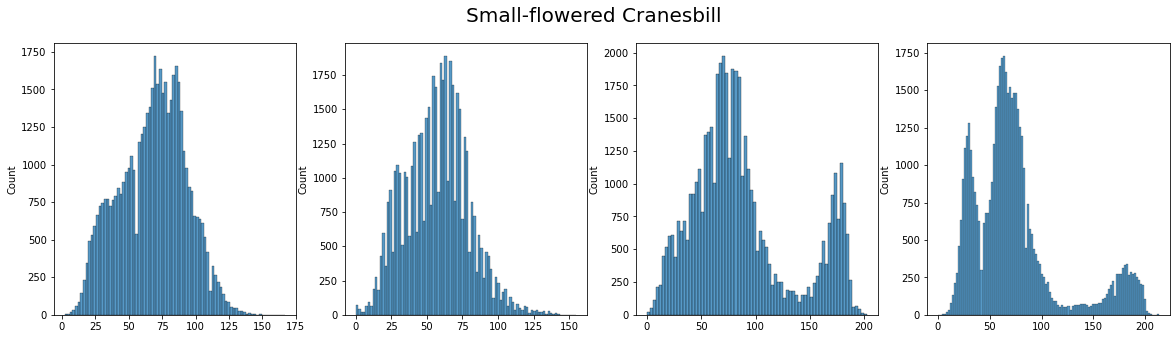

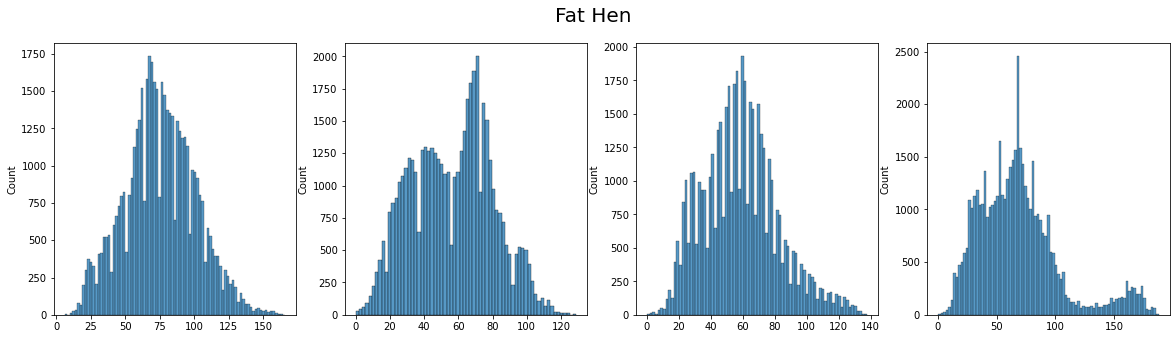

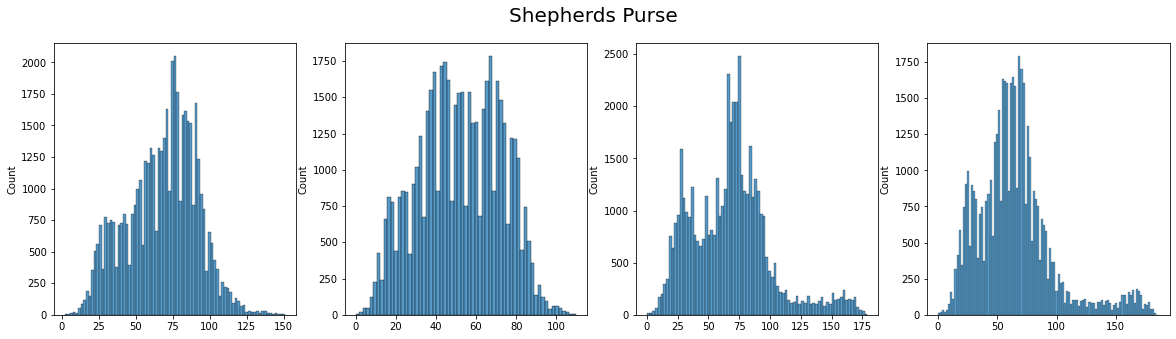

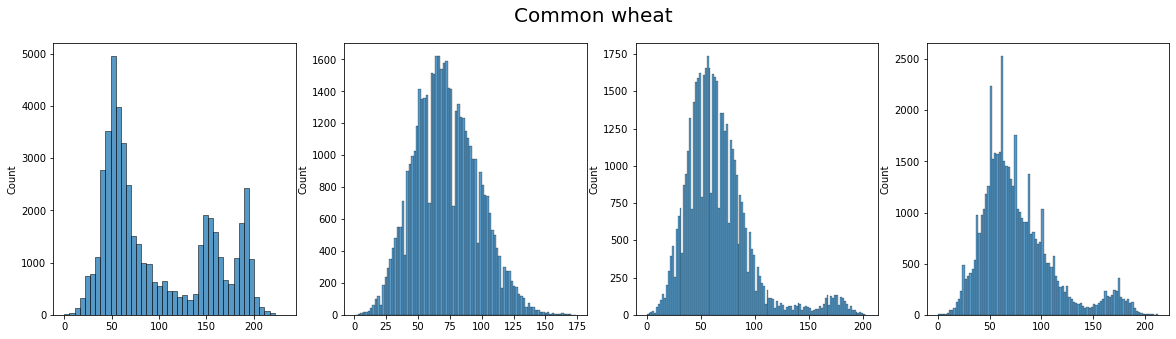

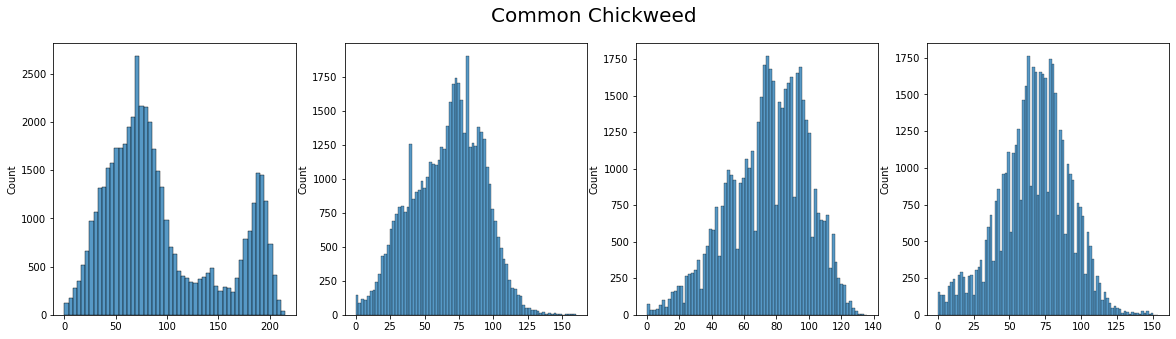

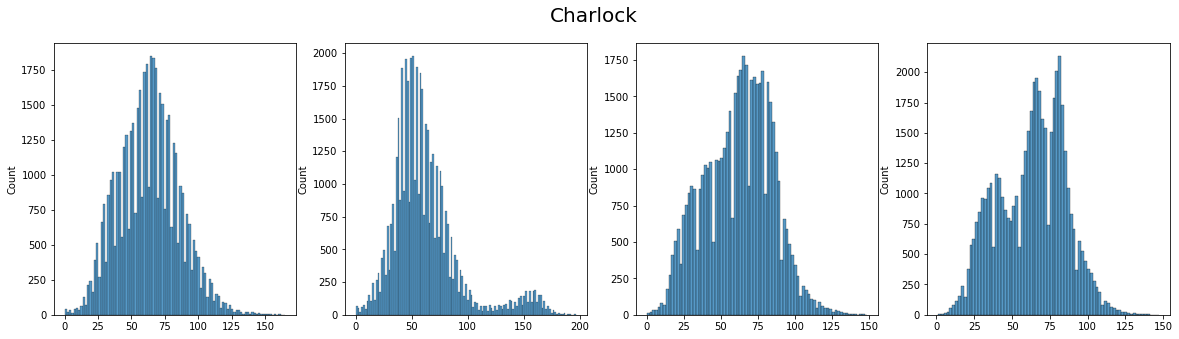

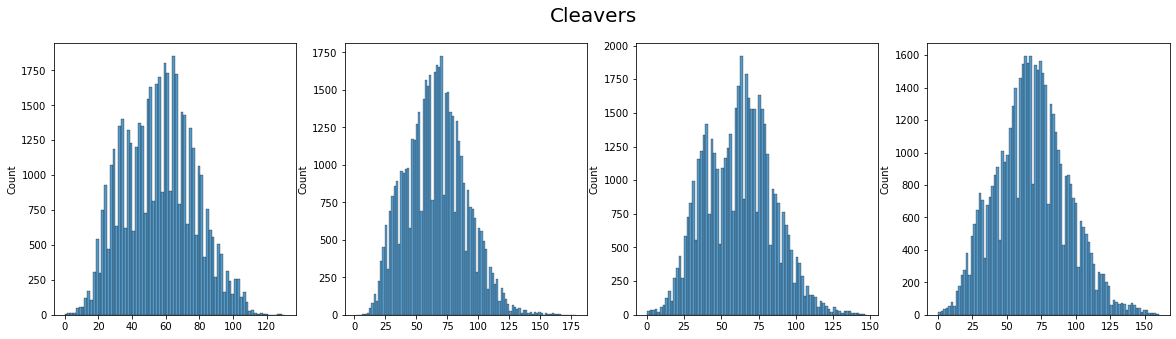

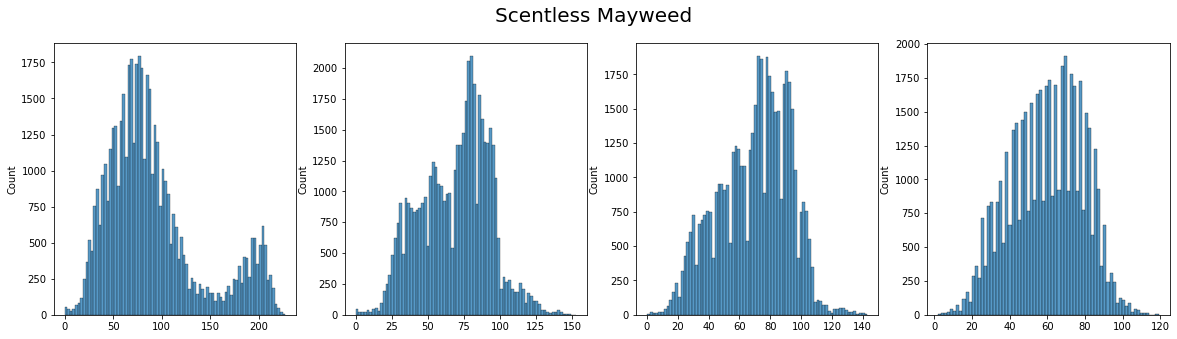

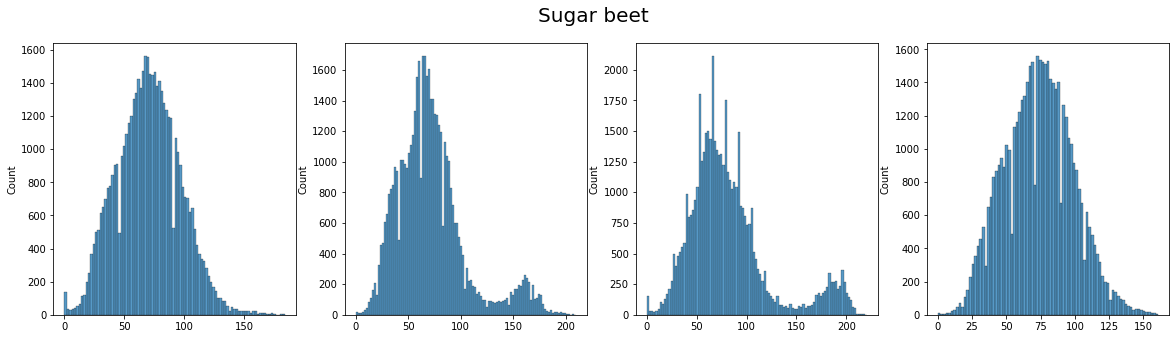

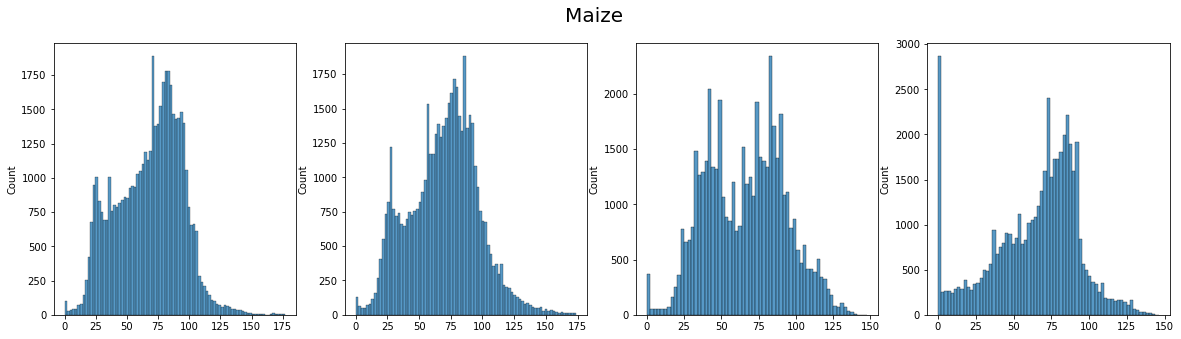

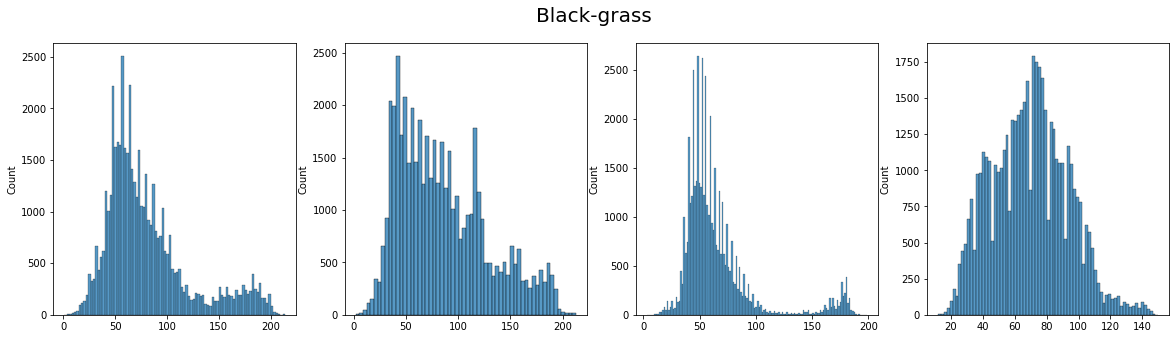

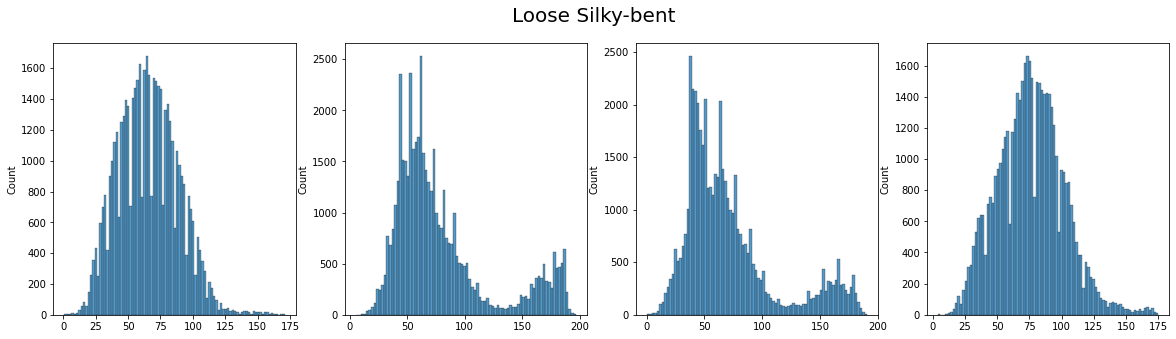

In [ ]:
# Pixel intensity histograms for above images
for i in indexes:
  fig, axes = plt.subplots(1, 4,  figsize=(20, 5))
  fig.suptitle(labels.iloc[i,0], fontsize=20)
  for j in range(4):
    sns.histplot(images[i + j].flatten(), ax=axes[j]);


As we can see from the pixel intensity histograms above, there is a lot of digital noise in the images.

# Data pre-processing

## Normalization

- We must normalize our data as it is always required in neural network models
- We can achieve this by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)
- Make sure that the values are float so that we can get decimal points after division

In [ ]:
# Diplaying range of pixel intensity in 8 bits color images
print('Maximum pixel intensity in images:', images.max())
print('Minimum pixel intensity in images:', images.min())

Maximum pixel intensity in images: 255
Minimum pixel intensity in images: 0


In [ ]:
# Normalization in order to have pixel intensity values ranging between 0 and 1
X = images.astype('float32')
X /= 255

## Gaussian blurring

Blurring helps removing the noise in the images and prevents the model from overfitting.

Original Image:  



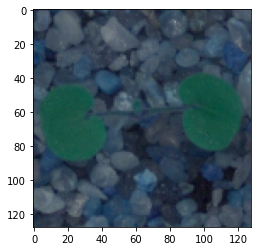


First blurring: 



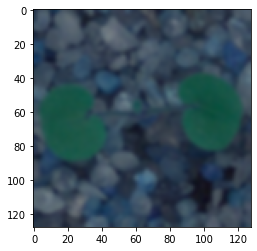


Second blurring: 



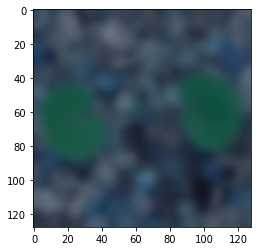

In [ ]:
# Blur the image with a kernel size of (5,5)
blur_1 = cv2.GaussianBlur(X[0], (5,5), 0)
# Blur the image with a kernel size of (15,15)
blur_2 = cv2.GaussianBlur(X[0], (15,15), 0)
print('Original Image:  \n')
plt.imshow(X[0])
plt.show()
print('\nFirst blurring: \n')
plt.imshow(blur_1)
plt.show()
print('\nSecond blurring: \n')
plt.imshow(blur_2)
plt.show()


A kernel size of 5 x 5 seems reasonable to remove the digital noise in the images while still preserving a good definition.

In [ ]:
# Applying the Gaussian blurring with 5 x 5 kernel size over the entire image dataset
for i in range(len(X)):
  X[i] = cv2.GaussianBlur(X[i], (5,5), 0)

## Visualizing data after pre-processing

In [ ]:
# Visualizing some of the images after pre-processing
for i in indexes:
  fig, axes = plt.subplots(1, 4,  figsize=(20, 5))
  fig.suptitle(labels.iloc[i,0], fontsize=20)
  for j in range(4):
    axes[j].imshow(X[i + j])

Output hidden; open in https://colab.research.google.com to view.

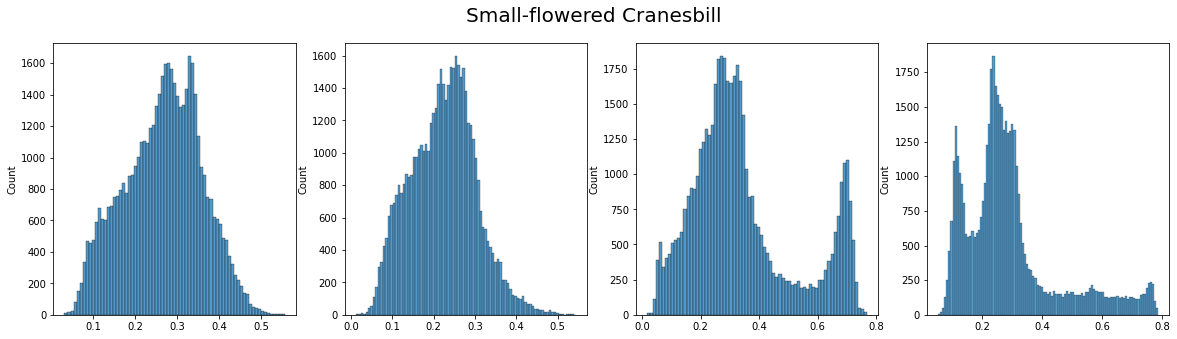

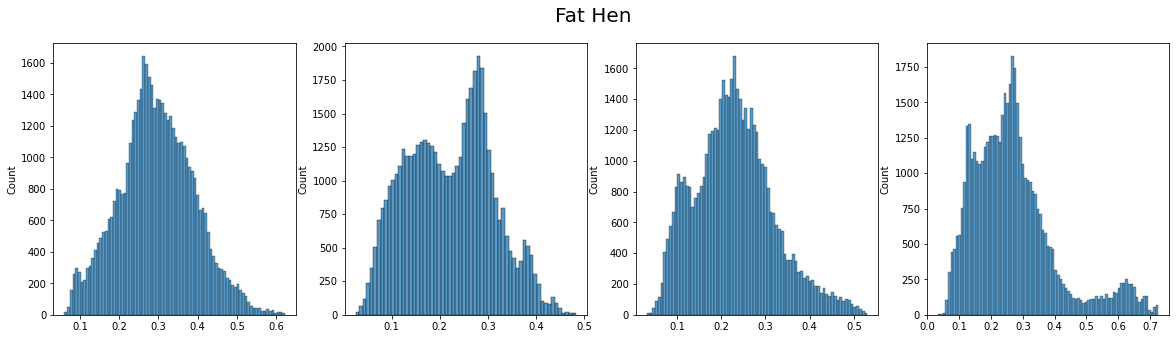

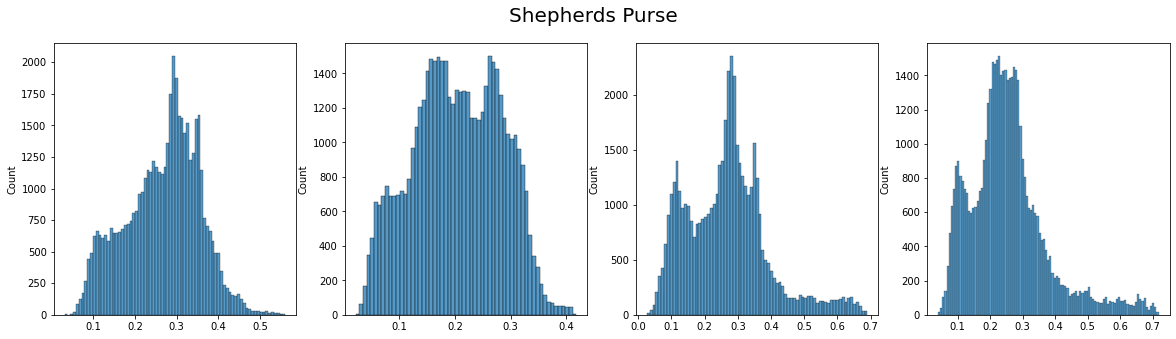

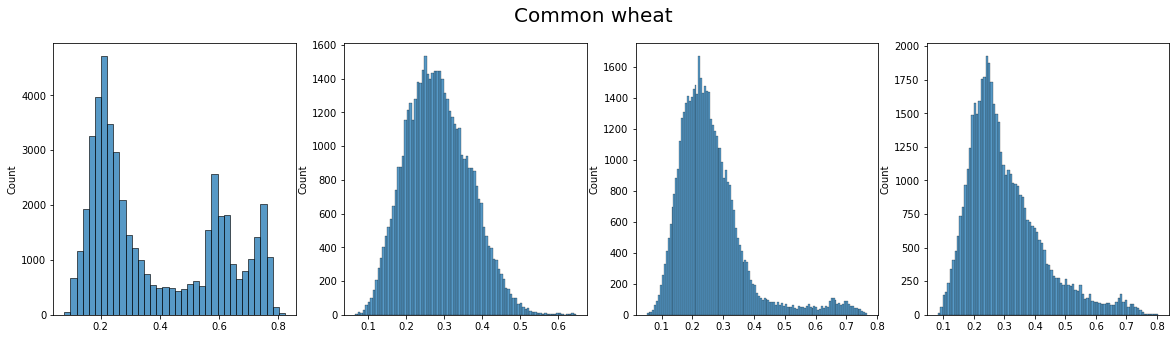

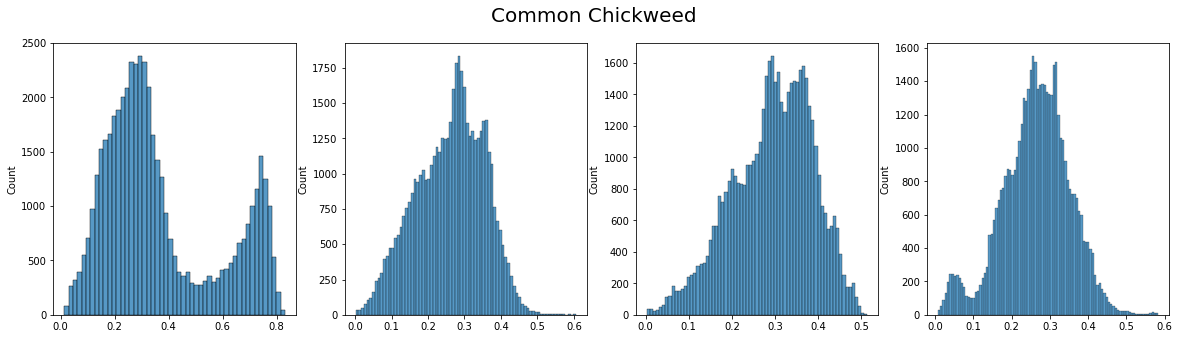

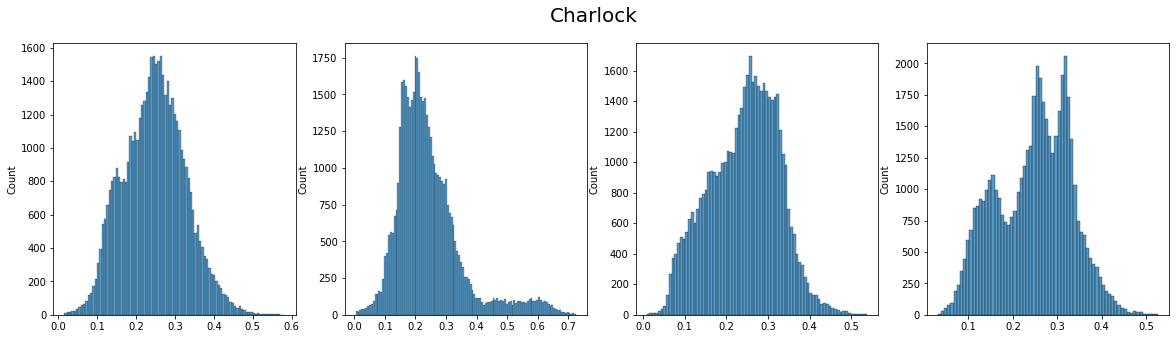

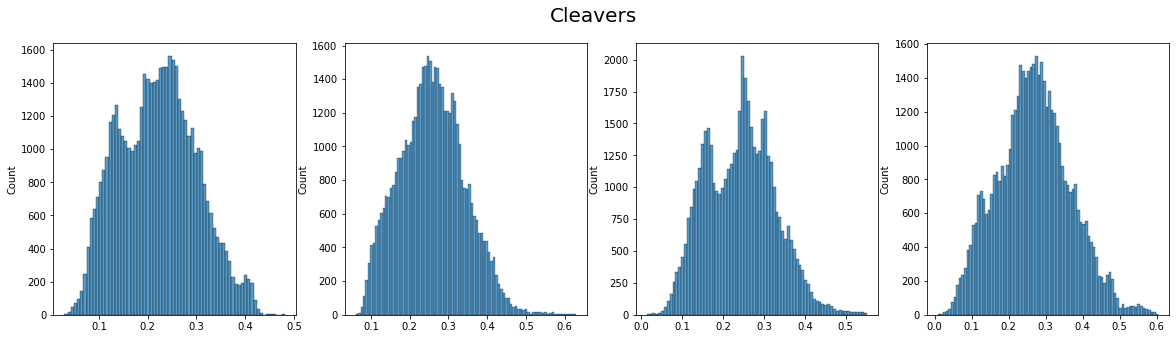

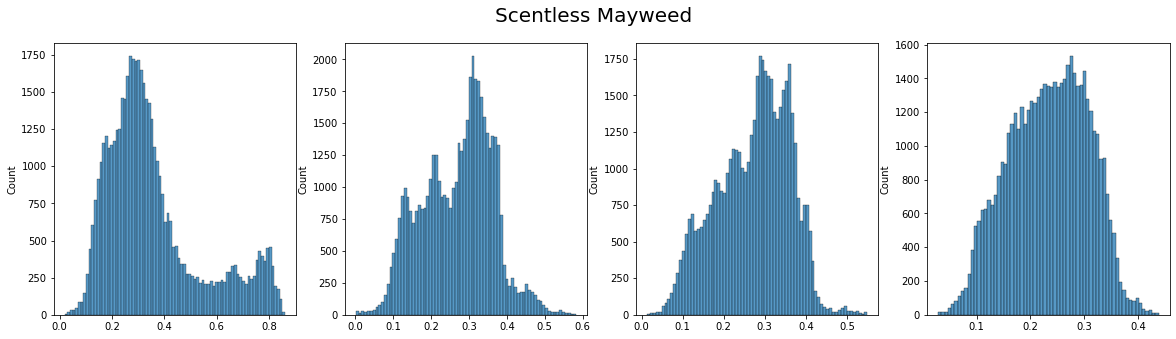

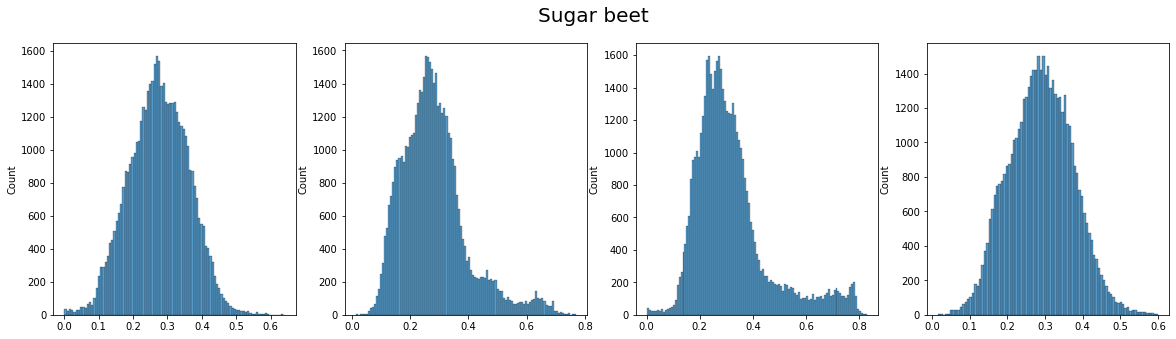

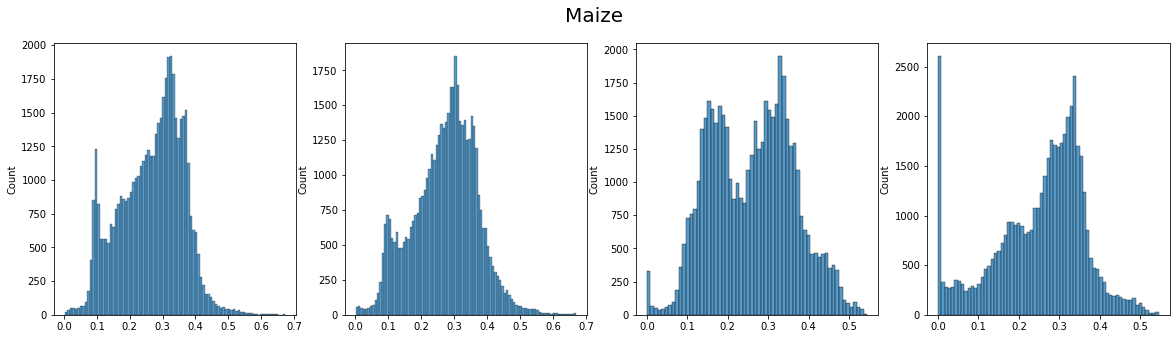

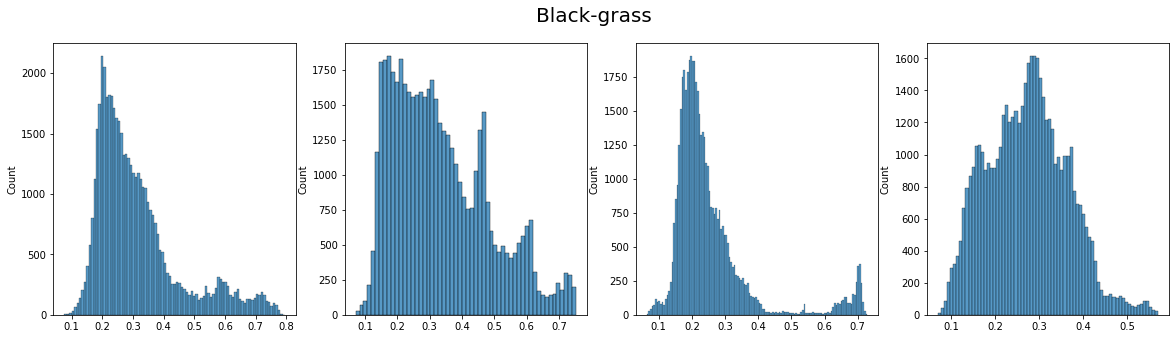

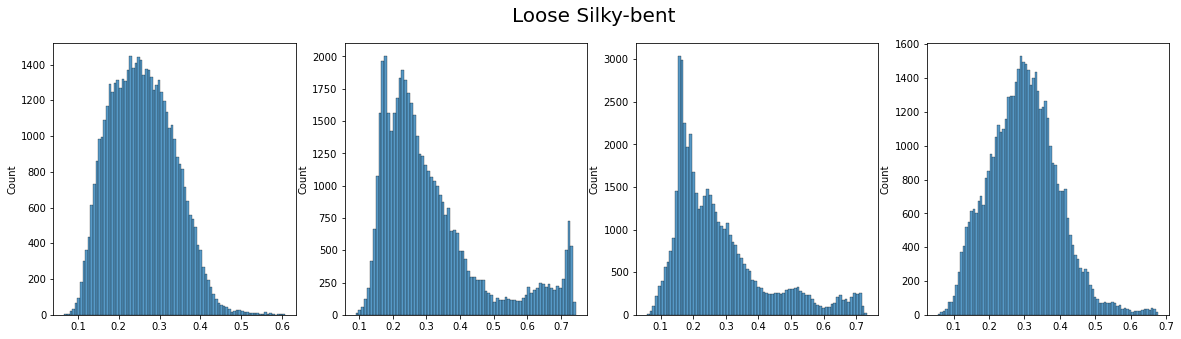

In [ ]:
# Pixel intensity histograms after pre-processing
for i in indexes:
  fig, axes = plt.subplots(1, 4,  figsize=(20, 5))
  fig.suptitle(labels.iloc[i,0], fontsize=20)
  for j in range(4):
    sns.histplot(X[i + j].flatten(), ax=axes[j]);

The distributions of pixel intensity show a smoother shape after blurring indicating that the digital noise has been removed.

# Make data compatible

## One hot encoding of labels

In [ ]:
# Creating a dictionary of labels
label_dict = {}
for idx, plant in enumerate(list(labels['Label'].unique())):
  label_dict[plant] = idx
print(label_dict)

{'Small-flowered Cranesbill': 0, 'Fat Hen': 1, 'Shepherds Purse': 2, 'Common wheat': 3, 'Common Chickweed': 4, 'Charlock': 5, 'Cleavers': 6, 'Scentless Mayweed': 7, 'Sugar beet': 8, 'Maize': 9, 'Black-grass': 10, 'Loose Silky-bent': 11}


In [ ]:
# Replacing text labels by numbers
y = labels['Label'].map(label_dict)

In [ ]:
# Convert labels to one-hot-vectors.
y = to_categorical(y)

In [ ]:
# Displaying shape of labels
y.shape

(4750, 12)

In [ ]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Train, validation and test sets

In [ ]:
# Splitting into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
# Training, validation and test sets shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_val:", X_val.shape[0])
print("Images in X_test:", X_test.shape[0])

X_train shape: (3325, 128, 128, 3)
y_train shape: (3325, 12)
Images in X_train: 3325
Images in X_val: 712
Images in X_test: 713


The input data is a 4-D tensor of shape [batch, height, width, channels] which is compatible with Keras models. The first dimension represents the image number, the second dimension the image height, the third the width and the fourth the (R,G,B) color channels.

# Building the CNN model

- Convolutional input layer, 32 feature maps with a size of 5×5 and a rectifier activation function.
- Batch Normalization Layer.
- Convolutional layer, 32 feature maps with a size of 5×5 and a rectifier activation function.
- Batch Normalization layer.
- Max Pool layer with size 2×2.
- Dropout layer at 25%.
---
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Batch Normalization layer.
- Dropout layer at 25%.
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Batch Normalization layer.
- Max Pool layer with size 2×2.
- Dropout layer at 25%.
---
- GlobalMaxPooling2D layer.
- Fully connected layer with 256 units and a rectifier activation function.
- Dropout layer at 50%.
- Fully connected output layer with 12 units and a softmax activation function

In [ ]:
# Set the CNN model

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)       

In [ ]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Fitting and evaluating the model

- We can fit this model with 500 epochs.
- In order to prevent the model from overfitting, we will use early stopping and model checkpoint callbacks to interrupt the training and save the weights showing the best performance.

In [ ]:
#Adding Early stopping callback to the fit function is going to stop the training
#if the val_accuracy is not going to change even '0.001' for more than 50 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

Epoch 1/500
104/104 [==============================] - 4s 30ms/step - loss: 3.3887 - accuracy: 0.2006 - val_loss: 2.5056 - val_accuracy: 0.1419

Epoch 00001: val_loss improved from inf to 2.50557, saving model to checkpoint_01_loss2.5056.h5
Epoch 2/500
104/104 [==============================] - 3s 27ms/step - loss: 1.8872 - accuracy: 0.3377 - val_loss: 2.9779 - val_accuracy: 0.1419

Epoch 00002: val_loss did not improve from 2.50557
Epoch 3/500
104/104 [==============================] - 3s 27ms/step - loss: 1.6536 - accuracy: 0.4283 - val_loss: 2.8089 - val_accuracy: 0.1419

Epoch 00003: val_loss did not improve from 2.50557
Epoch 4/500
104/104 [==============================] - 3s 27ms/step - loss: 1.4860 - accuracy: 0.4776 - val_loss: 2.9187 - val_accuracy: 0.1517

Epoch 00004: val_loss did not improve from 2.50557
Epoch 5/500
104/104 [==============================] - 3s 27ms/step - loss: 1.3632 - accuracy: 0.5305 - val_loss: 2.0030 - val_accuracy: 0.2963

Epoch 00005: val_loss impr

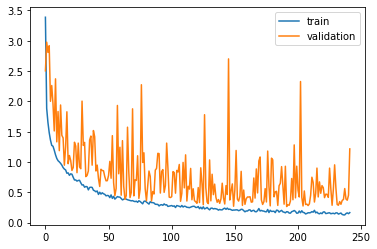

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=None,
                    epochs=500,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the weights that gave the best performance on validation set
model.load_weights('./checkpoint_192_loss0.2681.h5')

In [ ]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', np.round(scores[0], 4))
print('Test accuracy:', np.round(scores[1], 4))

23/23 [==============================] - 0s 11ms/step - loss: 0.2533 - accuracy: 0.9341
Test loss: 0.2533
Test accuracy: 0.9341


In [ ]:
y_pred = model.predict(X_test)

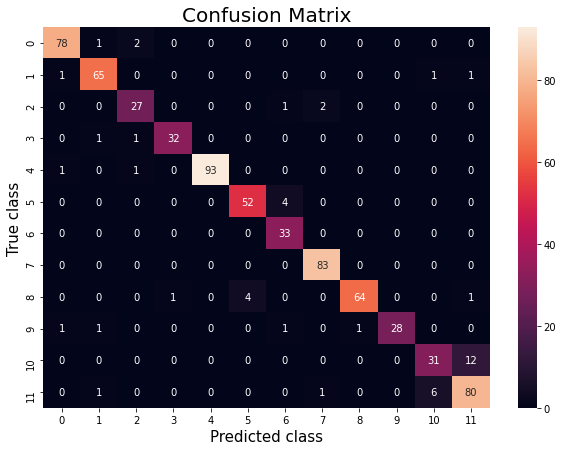

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted class', fontsize=15)
plt.ylabel('True class', fontsize=15);

In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        81
           1       0.94      0.96      0.95        68
           2       0.87      0.90      0.89        30
           3       0.97      0.94      0.96        34
           4       1.00      0.98      0.99        95
           5       0.93      0.93      0.93        56
           6       0.85      1.00      0.92        33
           7       0.97      1.00      0.98        83
           8       0.98      0.91      0.95        70
           9       1.00      0.88      0.93        32
          10       0.82      0.72      0.77        43
          11       0.85      0.91      0.88        88

    accuracy                           0.93       713
   macro avg       0.93      0.92      0.92       713
weighted avg       0.94      0.93      0.93       713



 - The model could achieve an accuracy of 93.4 % on the test set.
 - The model's performance is excellent to predict class 4 (Common Chickweed) and is worse to predict class 10 (Black-grass)
 - This difference in performance among classes can be explained by the number of image samples available in each class. There were 611 images of Common Chickweed vs 263 images of Black-grass available in the dataset.

# Model's predictions

In [ ]:
# Reverse the dictionary of labels
rev_label_dict = {v:k for k,v in label_dict.items()}
rev_label_dict

{0: 'Small-flowered Cranesbill',
 1: 'Fat Hen',
 2: 'Shepherds Purse',
 3: 'Common wheat',
 4: 'Common Chickweed',
 5: 'Charlock',
 6: 'Cleavers',
 7: 'Scentless Mayweed',
 8: 'Sugar beet',
 9: 'Maize',
 10: 'Black-grass',
 11: 'Loose Silky-bent'}

Model prediction for Test sample 2:
Predicted class: Loose Silky-bent
True class: Loose Silky-bent


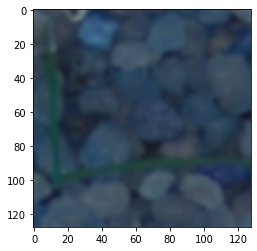

--------------------------------------------------
Model prediction for Test sample 3:
Predicted class: Fat Hen
True class: Fat Hen


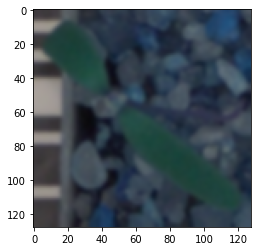

--------------------------------------------------
Model prediction for Test sample 33:
Predicted class: Small-flowered Cranesbill
True class: Small-flowered Cranesbill


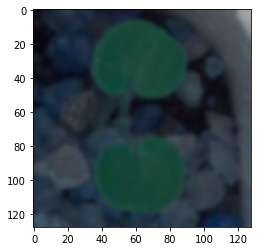

--------------------------------------------------
Model prediction for Test sample 36:
Predicted class: Black-grass
True class: Black-grass


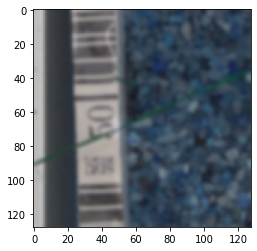

--------------------------------------------------
Model prediction for Test sample 59:
Predicted class: Charlock
True class: Charlock


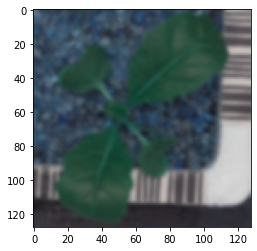

--------------------------------------------------


In [ ]:
# Checking model's prediction for test sample 2
print('Model prediction for Test sample 2:')
print('Predicted class:', rev_label_dict[model.predict(X_test[2].reshape(1, 128, 128, 3)).argmax()])
print('True class:', rev_label_dict[y_test[2].argmax()])
plt.imshow(X_test[2])
plt.show()
print(50 * '-')

# Checking model's prediction for test sample 3
print('Model prediction for Test sample 3:')
print('Predicted class:', rev_label_dict[model.predict(X_test[3].reshape(1, 128, 128, 3)).argmax()])
print('True class:', rev_label_dict[y_test[3].argmax()])
plt.imshow(X_test[3])
plt.show()
print(50 * '-')

# Checking model's prediction for test sample 33
print('Model prediction for Test sample 33:')
print('Predicted class:', rev_label_dict[model.predict(X_test[33].reshape(1, 128, 128, 3)).argmax()])
print('True class:', rev_label_dict[y_test[33].argmax()])
plt.imshow(X_test[33])
plt.show()
print(50 * '-')

# Checking model's prediction for test sample 36
print('Model prediction for Test sample 36:')
print('Predicted class:', rev_label_dict[model.predict(X_test[36].reshape(1, 128, 128, 3)).argmax()])
print('True class:', rev_label_dict[y_test[36].argmax()])
plt.imshow(X_test[36])
plt.show()
print(50 * '-')

# Checking model's prediction for test sample 59
print('Model prediction for Test sample 59:')
print('Predicted class:', rev_label_dict[model.predict(X_test[59].reshape(1, 128, 128, 3)).argmax()])
print('True class:', rev_label_dict[y_test[59].argmax()])
plt.imshow(X_test[59])
plt.show()
print(50 * '-')